In [86]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection  import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, r2_score, mean_absolute_percentage_error

df = pd.read_csv("diamonds.csv")
print("Рзамер данных")
print(df.shape)
print("Информация")
print(df.info())

Рзамер данных
(50000, 10)
Информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    50000 non-null  float64
 1   cut      50000 non-null  object 
 2   color    50000 non-null  object 
 3   clarity  50000 non-null  object 
 4   depth    50000 non-null  float64
 5   table    50000 non-null  float64
 6   price    50000 non-null  int64  
 7   x        50000 non-null  float64
 8   y        50000 non-null  float64
 9   z        50000 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.8+ MB
None


In [87]:
print("Описательная статистика")
print(df.describe())

Описательная статистика
              carat         depth         table         price             x  \
count  50000.000000  50000.000000  50000.000000  50000.000000  50000.000000   
mean       0.799444     61.753006     57.457830   3944.805440      5.734403   
std        0.475173      1.431088      2.232092   3997.938105      1.123077   
min        0.200000     43.000000     43.000000    326.000000      0.000000   
25%        0.400000     61.000000     56.000000    951.000000      4.710000   
50%        0.700000     61.800000     57.000000   2410.000000      5.700000   
75%        1.040000     62.500000     59.000000   5351.000000      6.540000   
max        5.010000     79.000000     95.000000  18823.000000     10.740000   

                  y             z  
count  50000.000000  50000.000000  
mean       5.737956      3.541056  
std        1.145579      0.707065  
min        0.000000      0.000000  
25%        4.720000      2.910000  
50%        5.710000      3.530000  
75%        6

In [88]:
print("Проверка пропусков:")
print(df.isnull().sum())
print("Пустых значений нету")

Проверка пропусков:
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64
Пустых значений нету


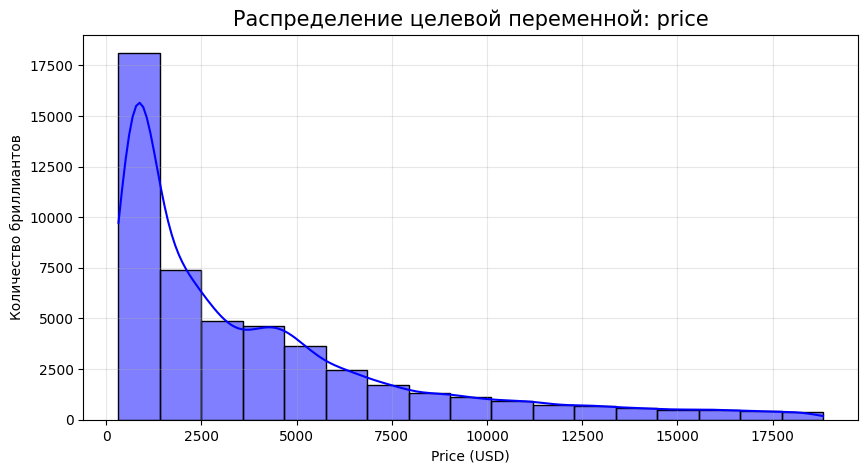

Экспоненциальное распределение
По графу видно, что в датасете преобладают дешевые бриллианты, а количество дорогих алмазов резко снижается с ростом цены.


In [89]:
#Распределение целевой переменной - price

intervals = 1 + 3.322 * math.log10(df.shape[0])
intervals = round(intervals)

plt.figure(figsize=(10,5))
sns.histplot(df['price'], bins=intervals, kde=True, color='blue')
plt.title("Распределение целевой переменной: price", fontsize=15)
plt.xlabel("Price (USD)")
plt.ylabel("Количество бриллиантов")
plt.grid(alpha=0.3)
plt.show()
print("Экспоненциальное распределение")
print("По графу видно, что в датасете преобладают дешевые бриллианты, а количество дорогих алмазов резко снижается с ростом цены.")

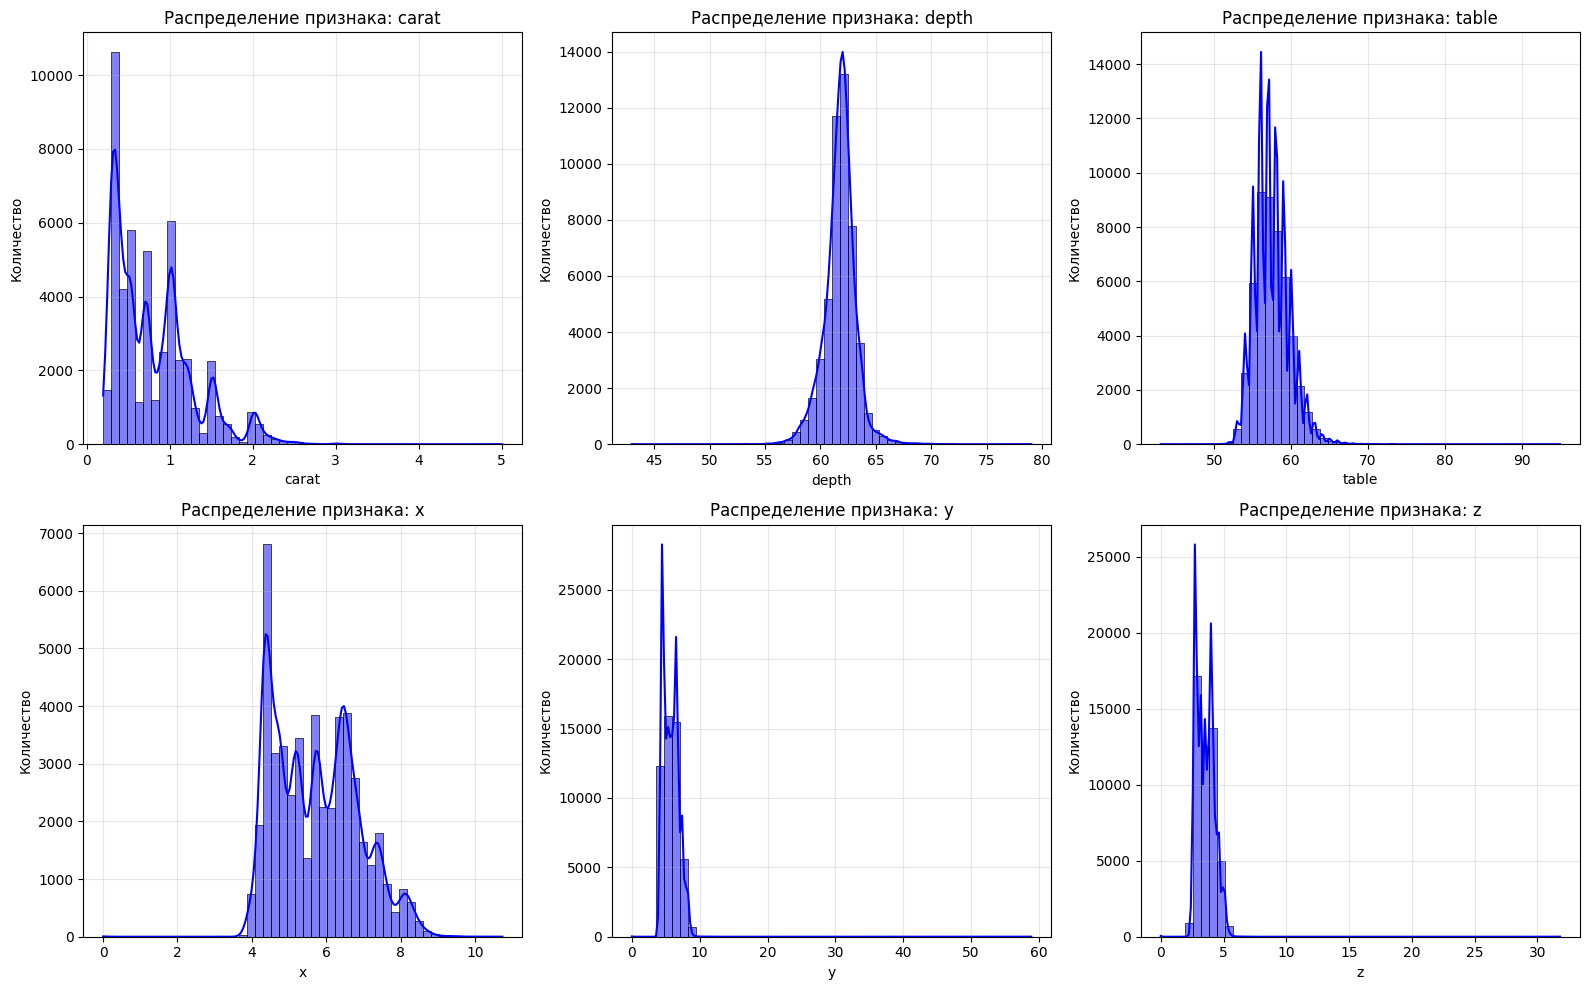

Распределие признаков глубины(depth) и верхней грани(table) являются нормальными
Остальные распределения не являются нормальными


In [90]:
#Визуализация числовых признаков
numeric_features = ['carat', 'depth', 'table', 'x', 'y', 'z']

plt.figure(figsize=(16,10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=True, color='blue')
    plt.title(f"Распределение признака: {col}")
    plt.xlabel(col)
    plt.ylabel("Количество")
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("Распределие признаков глубины(depth) и верхней грани(table) являются нормальными")
print("Остальные распределения не являются нормальными")


In [91]:
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(exclude=['object']).columns

print("Категориальные признаки:", list(cat_features))
print("Числовые признаки:", list(num_features))

Категориальные признаки: ['cut', 'color', 'clarity']
Числовые признаки: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']


In [92]:
df_clean = df.copy()
label_encoders = {}
for column in cat_features:
    le = LabelEncoder()
    df_clean[column] = le.fit_transform(df_clean[column].astype(str))
    label_encoders[column] = le
    print(f"Закодирован признак: {column}")
print("Размер данных после кодирования:", df_clean.shape)
print("Закодировал категориальные признаки: cut, color и clarity для преобразования текстовых значений в числовые,")
print("чтобы модели машинного обучения могли обрабатывать категориальные данные.")

Закодирован признак: cut
Закодирован признак: color
Закодирован признак: clarity
Размер данных после кодирования: (50000, 10)
Закодировал категориальные признаки: cut, color и clarity для преобразования текстовых значений в числовые,
чтобы модели машинного обучения могли обрабатывать категориальные данные.


In [93]:
scaler = StandardScaler()

# Разделяем на признаки и целевую переменную
X = df_clean.drop('price', axis=1)
y = df_clean['price']

X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("Данные после нормализации:")
print(X_scaled.head())

print("Данные успешно нормализованы - все признаки теперь имеют среднее значение, близкое к 0, и стандартное отклонение, равное 1.")

Данные после нормализации:
      carat       cut     color   clarity     depth     table         x  \
0 -1.198405 -0.538215 -0.940237 -0.485467 -0.176795 -1.101144 -1.588868   
1 -1.240495  0.434451 -0.940237 -1.065794 -1.364714  1.586944 -1.642293   
2 -1.198405 -1.510880 -0.940237  0.094860 -3.391165  3.379003 -1.499826   
3 -1.072134  0.434451  1.412150  0.675187  0.452104  0.242900 -1.366263   
4 -1.030043 -1.510880  2.000246 -0.485467  1.081003  0.242900 -1.241604   

          y         z  
0 -1.534572 -1.571380  
1 -1.656782 -1.741097  
2 -1.456009 -1.741097  
3 -1.316340 -1.288517  
4 -1.211588 -1.118800  
Данные успешно нормализованы - все признаки теперь имеют среднее значение, близкое к 0, и стандартное отклонение, равное 1.


In [94]:
#Анализ категориальных переменных
def analyze_coded(df_clean, original_df, cat_features, label_encoders):
    
    for feature in cat_features:
        print(f"\n{feature}")
        
        le = label_encoders[feature]
        
        print("Кодировка:")
        for code, category in enumerate(le.classes_):
            count = (df_clean[feature] == code).sum()
            print(f"  {code} → '{category}' (количество: {count})")
        
        most_frequent_code = df_clean[feature].mode()[0]
        most_frequent_category = le.inverse_transform([most_frequent_code])[0]
        print(f"Самая частая категория: '{most_frequent_category}' (код: {most_frequent_code})")
        
        print(f"Количество различных категорий: {len(le.classes_)}")

analyze_coded(df_clean, df, cat_features, label_encoders)

print("Проведен анализ категориальных признаков после кодирования.")


cut
Кодировка:
  0 → 'Fair' (количество: 1495)
  1 → 'Good' (количество: 4557)
  2 → 'Ideal' (количество: 19938)
  3 → 'Premium' (количество: 12806)
  4 → 'Very Good' (количество: 11204)
Самая частая категория: 'Ideal' (код: 2)
Количество различных категорий: 5

color
Кодировка:
  0 → 'D' (количество: 6224)
  1 → 'E' (количество: 9085)
  2 → 'F' (количество: 8864)
  3 → 'G' (количество: 10452)
  4 → 'H' (количество: 7711)
  5 → 'I' (количество: 5058)
  6 → 'J' (количество: 2606)
Самая частая категория: 'G' (код: 3)
Количество различных категорий: 7

clarity
Кодировка:
  0 → 'I1' (количество: 688)
  1 → 'IF' (количество: 1632)
  2 → 'SI1' (количество: 12115)
  3 → 'SI2' (количество: 8519)
  4 → 'VS1' (количество: 7579)
  5 → 'VS2' (количество: 11404)
  6 → 'VVS1' (количество: 3369)
  7 → 'VVS2' (количество: 4694)
Самая частая категория: 'SI1' (код: 2)
Количество различных категорий: 8
Проведен анализ категориальных признаков после кодирования.


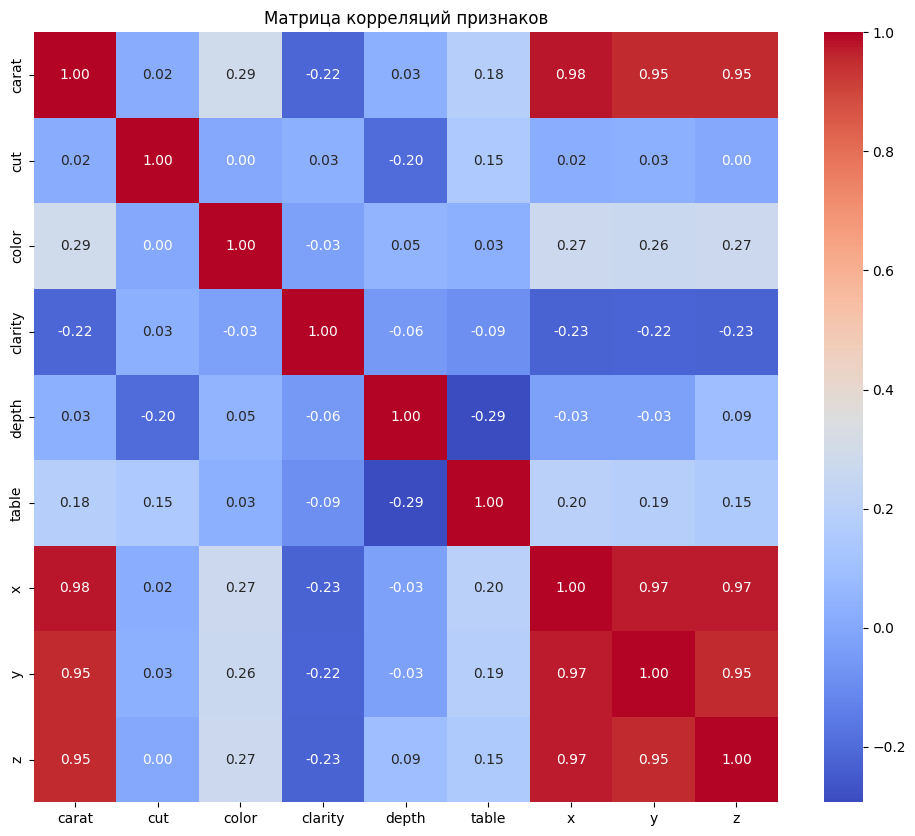

По матрице можно увидеть мультиколлинеарльность между такими признаками, как carat(масса), x, y, z(ширина, высота, длина),
что показаывает высокую взаимосвзь между массой и геометрическими параметрами бриллианта.
И это верно, т.к. масса бриллианта напрямую зависит от его физическиз размеров.


In [95]:
# Матрица корреляций
corr_matrix = X_scaled.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Матрица корреляций признаков")
plt.show()
print("По матрице можно увидеть мультиколлинеарльность между такими признаками, как carat(масса), x, y, z(ширина, высота, длина),")
print("что показаывает высокую взаимосвзь между массой и геометрическими параметрами бриллианта.")
print("И это верно, т.к. масса бриллианта напрямую зависит от его физическиз размеров.")

In [96]:
# VIF
X_vif = X_scaled.copy()

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data = vif_data.sort_values(by="VIF", ascending=False)
print(vif_data)
print("Анализ VIF показывает наличие сильной мультиколлинеарности между прищнаками x, y, z и carat")
print("VIF = 1~ - признак независим")
print("VIF от 5 до 10 - умеренная зависимость")
print("VIF > 10 - сильная мультиколлинеарность")

   feature        VIF
6        x  54.742321
8        z  22.837067
0    carat  21.905477
7        y  19.179367
4    depth   1.527230
5    table   1.158660
2    color   1.099832
3  clarity   1.067406
1      cut   1.054075
Анализ VIF показывает наличие сильной мультиколлинеарности между прищнаками x, y, z и carat
VIF = 1~ - признак независим
VIF от 5 до 10 - умеренная зависимость
VIF > 10 - сильная мультиколлинеарность


In [97]:
#Регрессии линейная, гребневая
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

def otsenka_models(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    
    mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    print(f"\n{model_name}:")
    print(f"RMSE (train/test): {rmse_train:.2f}/{rmse_test:.2f}")
    print(f"R² (train/test): {r2_train:.3f}/{r2_test:.3f}")
    print(f"MAPE (train/test): {mape_train:.2f}%/{mape_test:.2f}%")
    print(f"R² кросс-валидация: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    return {
        'model': model_name,
        'rmse_train': rmse_train,
        'rmse_test': rmse_test,
        'r2_train': r2_train,
        'r2_test': r2_test,
        'mape_train': mape_train,
        'mape_test': mape_test,
        'cv_score': cv_scores.mean()
    }

lr = LinearRegression()
lr_results = otsenka_models(lr, X_train, X_test, y_train, y_test, "Линейная регрессия")

ridge = Ridge(alpha=1.0)
ridge_results = otsenka_models(ridge, X_train, X_test, y_train, y_test, "Гребневая регрессия")

original_results = [lr_results, ridge_results]

print("Из полоученных данных видно, что линейная и гребневая регрессии показывают аналогичные результаты")
print("Линейная и гребневая регресси хорошо предсказывают цену бриллиантов. Модель объясняет")
print("примерно 89% вариации цены R2 = 0,887~. Средняя ошибка предсказания составляет около 1320$, а средняя процентная ошибка около 38%")
print("Кросс-валидация показывает стабильность моделей")



Линейная регрессия:
RMSE (train/test): 1362.73/1320.04
R² (train/test): 0.885/0.887
MAPE (train/test): 38.47%/38.20%
R² кросс-валидация: 0.883 (+/- 0.008)

Гребневая регрессия:
RMSE (train/test): 1362.73/1319.97
R² (train/test): 0.885/0.887
MAPE (train/test): 38.47%/38.21%
R² кросс-валидация: 0.884 (+/- 0.008)
Из полоученных данных видно, что линейная и гребневая регрессии показывают аналогичные результаты
Линейная и гребневая регресси хорошо предсказывают цену бриллиантов. Модель объясняет
примерно 89% вариации цены R2 = 0,887~. Средняя ошибка предсказания составляет около 1320$, а средняя процентная ошибка около 38%
Кросс-валидация показывает стабильность моделей


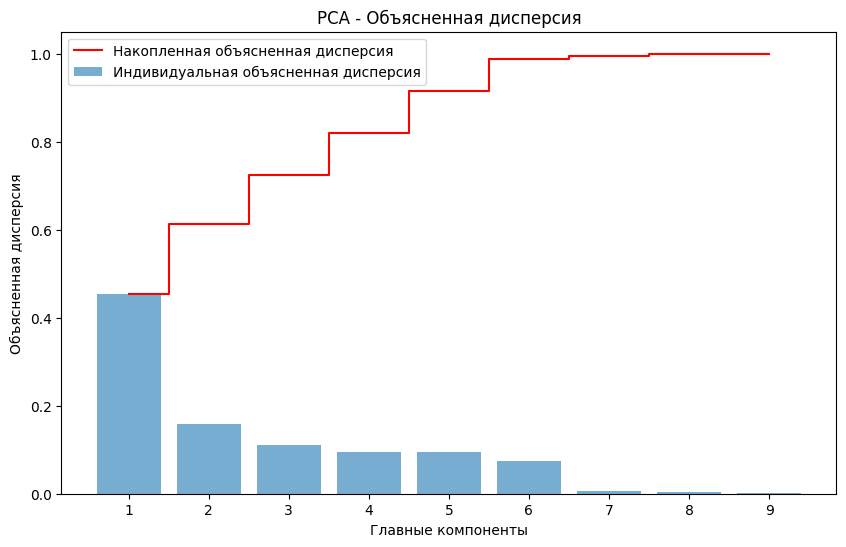

Количество компонент для 95% дисперсии: 6
Исходная размерность: (50000, 9)
Размерность после PCA: (50000, 6)
Объясненная дисперсия: 0.989
Уменьшили размерность с 9 до 6, потеряв ~1% информации


In [98]:
#PCA без ограничения количества компонент
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Объясненная дисперсия каждой компоненты и накопленная
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, 
        label='Индивидуальная объясненная дисперсия')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, 
         where='mid', label='Накопленная объясненная дисперсия', color='red')
plt.ylabel('Объясненная дисперсия')
plt.xlabel('Главные компоненты')
plt.xticks(range(1, len(explained_variance) + 1))
plt.legend()
plt.title('PCA - Объясненная дисперсия')
plt.show()

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Количество компонент для 95% дисперсии: {n_components_95}")

pca_final = PCA(n_components=n_components_95)
X_pca_final = pca_final.fit_transform(X_scaled)

print(f"Исходная размерность: {X_scaled.shape}")
print(f"Размерность после PCA: {X_pca_final.shape}")
print(f"Объясненная дисперсия: {pca_final.explained_variance_ratio_.sum():.3f}")
print("Уменьшили размерность с 9 до 6, потеряв ~1% информации")

In [99]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca_final, y, test_size=0.2, random_state=42
)

lr_pca = LinearRegression()
lr_pca_results = otsenka_models(lr_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca, 
                               "Линейная регрессия (PCA)")

ridge_pca = Ridge(alpha=1.0)
ridge_pca_results = otsenka_models(ridge_pca, X_train_pca, X_test_pca, y_train_pca, y_test_pca, 
                                  "Гребневая регрессия (PCA)")

pca_results = [lr_pca_results, ridge_pca_results]


Линейная регрессия (PCA):
RMSE (train/test): 1641.61/1700.11
R² (train/test): 0.833/0.813
MAPE (train/test): 64.16%/64.51%
R² кросс-валидация: 0.833 (+/- 0.010)

Гребневая регрессия (PCA):
RMSE (train/test): 1641.61/1700.11
R² (train/test): 0.833/0.813
MAPE (train/test): 64.16%/64.50%
R² кросс-валидация: 0.833 (+/- 0.010)



Сравнение результатов

                       model   r2_test    rmse_test  mape_test  cv_score
0         Линейная регрессия  0.887266  1320.040811  38.202820  0.883447
1        Гребневая регрессия  0.887278  1319.969344  38.208488  0.883501
2   Линейная регрессия (PCA)  0.813002  1700.113207  64.505019  0.832682
3  Гребневая регрессия (PCA)  0.813003  1700.110026  64.503623  0.832682


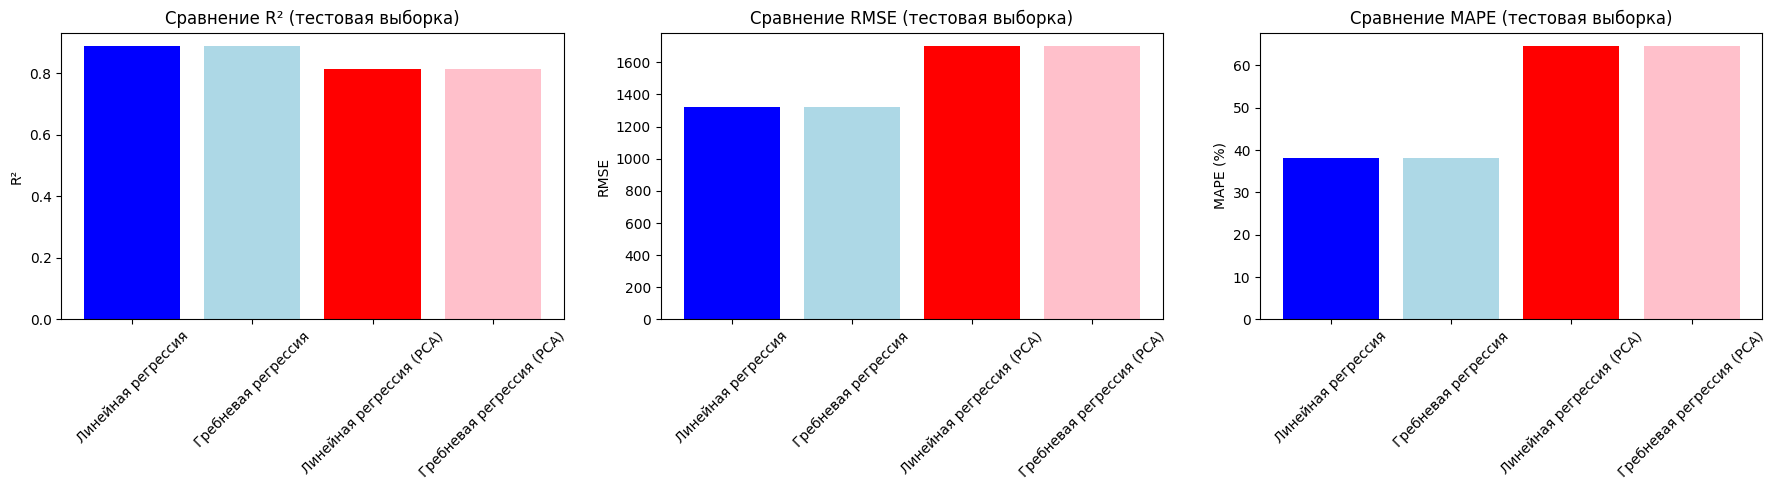


Важность признаков в исходной модели:
   feature   importance
0    carat  5172.229611
6        x  1455.783626
3  clarity   497.707235
2    color   457.319787
7        y   245.988630
4    depth   221.202510
5    table   210.176981
1      cut    74.208856
8        z    15.707613
Применение РСА ухудшило качество моделей - метрики R2 и RMSE снизились
Возможно это произошло из-за того, что РСА удалил не только мультиколлериальность, но и часть полезной информации


In [100]:
print("\nСравнение результатов\n")

comparison_df = pd.DataFrame(original_results + pca_results)
print(comparison_df[['model', 'r2_test', 'rmse_test', 'mape_test', 'cv_score']])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = comparison_df['model']
r2_scores = comparison_df['r2_test']
axes[0].bar(models, r2_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[0].set_title('Сравнение R² (тестовая выборка)')
axes[0].set_ylabel('R²')
axes[0].tick_params(axis='x', rotation=45)

rmse_scores = comparison_df['rmse_test']
axes[1].bar(models, rmse_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[1].set_title('Сравнение RMSE (тестовая выборка)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=45)

mape_scores = comparison_df['mape_test']
axes[2].bar(models, mape_scores, color=['blue', 'lightblue', 'red', 'pink'])
axes[2].set_title('Сравнение MAPE (тестовая выборка)')
axes[2].set_ylabel('MAPE (%)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

if hasattr(lr, 'coef_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': abs(lr.coef_)
    }).sort_values('importance', ascending=False)
    
    print("\nВажность признаков в исходной модели:")
    print(feature_importance)

    print("Применение РСА ухудшило качество моделей - метрики R2 и RMSE снизились")
    print("Возможно это произошло из-за того, что РСА удалил не только мультиколлериальность, но и часть полезной информации")

In [101]:
print("\nВывод\n")

best_model_original = comparison_df.loc[comparison_df['r2_test'].idxmax()]
print(f"1. Качество моделей:")
print(f"   Лучшая модель на исходных признаках: {best_model_original['model']} (R² = {best_model_original['r2_test']:.3f})")

r2_original_best = max(comparison_df.loc[comparison_df['model'].isin(['Линейная регрессия', 'Гребневая регрессия']), 'r2_test'])
r2_pca_best = max(comparison_df.loc[comparison_df['model'].str.contains('PCA'), 'r2_test'])

print(f"2. Влияние PCA:")
if r2_pca_best > r2_original_best:
    print("   PCA улучшило качество модели")
elif r2_pca_best < r2_original_best:
    print("   PCA ухудшило качество модели")
else:
    print("   PCA не повлияло на качество модели")



Вывод

1. Качество моделей:
   Лучшая модель на исходных признаках: Гребневая регрессия (R² = 0.887)
2. Влияние PCA:
   PCA ухудшило качество модели
